# Complete Guide to Pinard Library Usage

This notebook provides a comprehensive guide to using the pinard library for machine learning pipelines, from simple data loading and visualization to complex model training, fine-tuning, and custom transformations.

We'll cover:
1. Basic setup and data loading
2. Data visualization and exploration
3. Simple processing pipelines
4. Training different types of models:
   - sklearn models
   - TensorFlow models
   - Custom models
5. Fine-tuning different types of models
6. Advanced pipeline configurations with transformations
7. Working with classification and regression tasks
8. Custom transformations

Let's get started by importing the necessary libraries and setting up our environment.

## 1. Setup and Imports

First, let's import all the necessary libraries and modules:

In [75]:
%reload_ext autoreload
%autoreload 2


import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Add the parent directory to sys.path to import pinard
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))  

# Import pinard modules
from pinard.presets.ref_models import decon, nicon, customizable_nicon, nicon_classification
from pinard.presets.preprocessings import decon_set, nicon_set
from pinard.data_splitters import KennardStoneSplitter
from pinard.transformations import StandardNormalVariate as SNV, SavitzkyGolay as SG, Gaussian as GS, Derivate as Dv
from pinard.transformations import Rotate_Translate as RT, Spline_X_Simplification as SXS, Random_X_Operation as RXO
from pinard.transformations import CropTransformer
from pinard.core.runner import ExperimentRunner
from pinard.core.config import Config
from pinard.core.utils import framework

# Import sklearn modules
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seed for reproducibility
seed = 42

## 2. Data Loading and Exploration

Let's start by exploring the available datasets. These datasets come pre-packaged with the pinard library.

In [76]:
# List available datasets
sample_data_dir = "../sample_data"
datasets = os.listdir(sample_data_dir)
print("Available datasets:")
for dataset in datasets:
    print(f"- {dataset}")

Available datasets:
- CoffeeSpecies
- Malaria2024
- mock_data
- mock_data2
- mock_data3
- mock_data3_binary
- mock_data3_classif
- WhiskyConcentration


Let's load and explore one of the datasets. We'll use the WhiskyConcentration dataset for regression tasks and the Malaria2024 dataset for classification tasks.

In [77]:
from pinard.data.dataset_loader import get_dataset

# Load regression dataset
whisky_dataset = get_dataset("../sample_data/WhiskyConcentration")
print("Whisky Dataset Info:")
print(whisky_dataset.to_str())

# Load classification dataset
malaria_dataset = get_dataset("../sample_data/Malaria2024")
print("Malaria Dataset Info:")
print(malaria_dataset.to_str())
print(f"- Unique classes: {np.unique(malaria_dataset.y_train)}")

>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.
Whisky Dataset Info:
Dataset(x_train:(261, 5248, 1) - y_train:(261, 1), x_test:(263, 5248, 1) - y_test:(263, 1))
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.
Malaria Dataset Info:
Dataset(x_train:(2996, 1665, 1) - y_train:(2996, 1), x_test:(1285, 1665, 1) - y_test:(1285, 1))
- Unique classes: [0. 1.]


Let's visualize the data to get a better understanding of what we're working with:

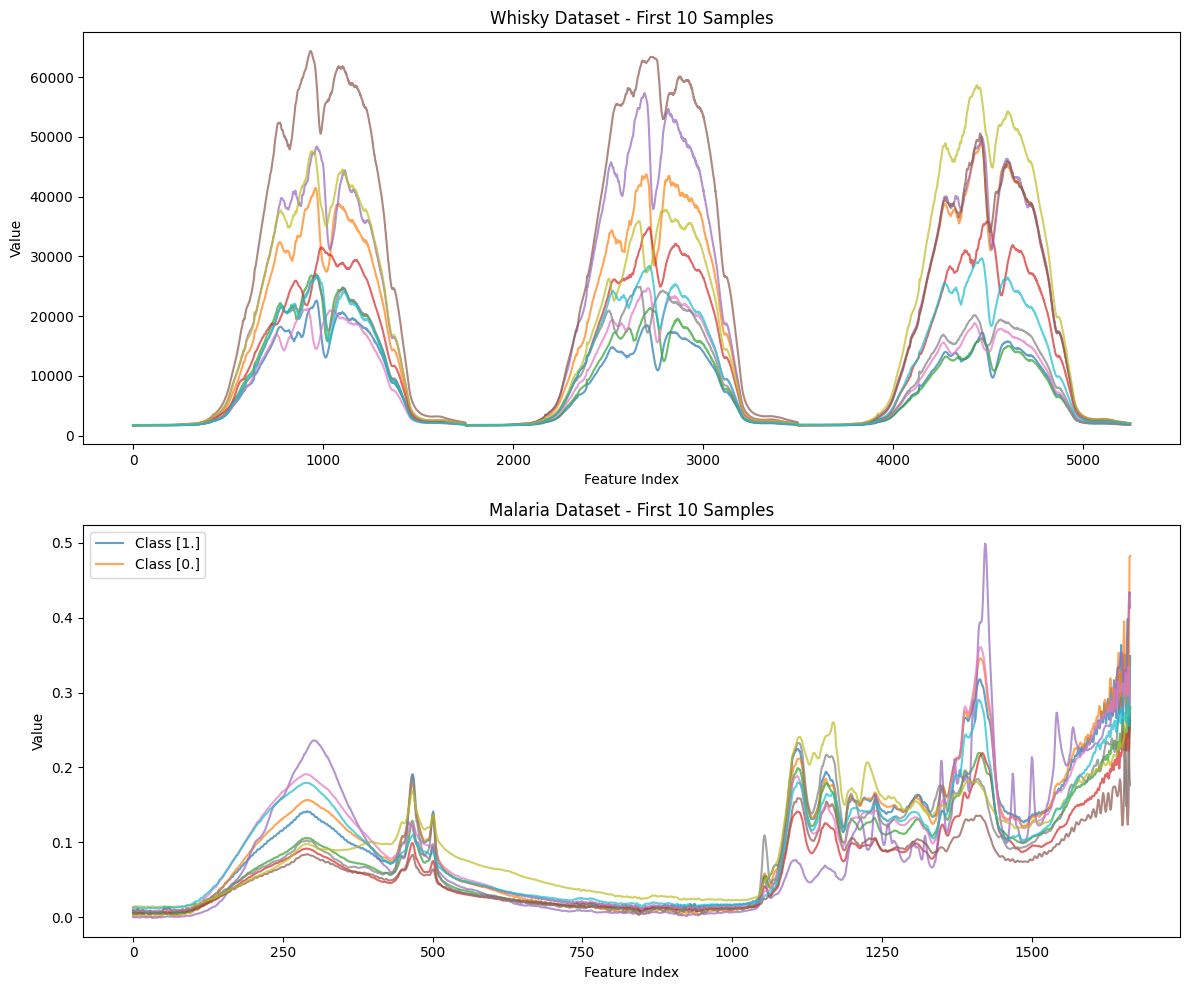

In [88]:
plt.figure(figsize=(12, 10))

# Plot the whisky dataset (first 10 samples)
plt.subplot(2, 1, 1)
for i in range(min(10, whisky_dataset.x_train_().shape[0])):
    plt.plot(whisky_dataset.x_train_()[i], alpha=0.7)
plt.title('Whisky Dataset - First 10 Samples')
plt.xlabel('Feature Index')
plt.ylabel('Value')

# Plot the malaria dataset (first 10 samples)
plt.subplot(2, 1, 2)
for i in range(min(10, malaria_dataset.x_train_().shape[0])):
    plt.plot(malaria_dataset.x_train_()[i], alpha=0.7, label=f'Class {malaria_dataset.y_train[i]}' if i < 2 else '')
plt.title('Malaria Dataset - First 10 Samples')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Basic Processing Pipeline

Now, let's create a simple processing pipeline using pinard's transformations. This will demonstrate how to preprocess data before training models.

In [83]:
# Define a simple processing pipeline
simple_pipeline = [
    RobustScaler(),  # Step 1: Scale the data
    {"split": RepeatedKFold(n_splits=3, n_repeats=1)},  # Step 2: Define cross-validation splits
    MinMaxScaler()  # Step 3: Scale the data again after splitting
]

# Create a basic configuration
y_pipeline = MinMaxScaler()  # For scaling the target variable
basic_config = Config("../sample_data/WhiskyConcentration", simple_pipeline, y_pipeline, None, None, seed)

# Run the experiment with processing only (no model)
start = time.time()
runner = ExperimentRunner([basic_config], resume_mode="restart")
datasets, _, _, _  = runner.run()
dataset = datasets[0]
end = time.time()
print(f"Processing time: {end-start:.2f} seconds")

# Examine the processed dataset
print(f"Processed dataset X shape: {dataset.x_train_().shape}")
print(f"Processed dataset y shape: {dataset.y_train.shape}")

2025-04-03 15:51:35,840 - INFO - ================================================================================
2025-04-03 15:51:35,841 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=None, experiment=None, seed=42)
2025-04-03 15:51:35,843 - INFO - ================================================================================
2025-04-03 15:51:35,843 - INFO - ### LOADING DATASET ###


>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 15:51:41,726 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 15:51:41,727 - INFO - ### PROCESSING DATASET ###
2025-04-03 15:51:42,121 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 15:51:42,122 - INFO - ### PREPARING MODEL ###
2025-04-03 15:51:42,123 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Processing time: 6.31 seconds
Processed dataset X shape: (261, 5248)
Processed dataset y shape: (261, 1)


Let's visualize the processed data to see how it differs from the original:

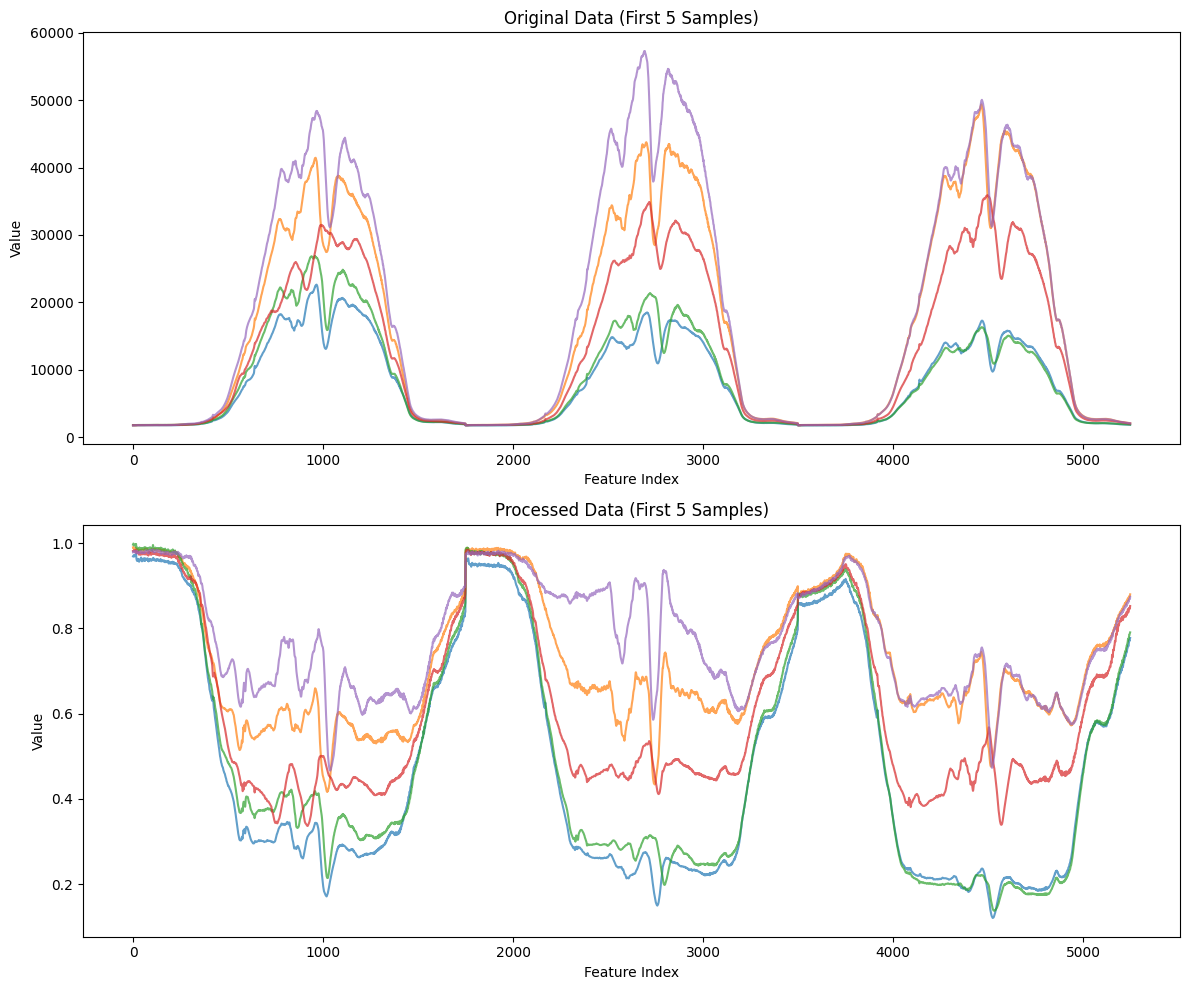

In [87]:
plt.figure(figsize=(12, 10))

# Plot original data
plt.subplot(2, 1, 1)
for i in range(min(5, whisky_dataset.x_train_().shape[0])):
    plt.plot(whisky_dataset.x_train_()[i], alpha=0.7)
plt.title('Original Data (First 5 Samples)')
plt.xlabel('Feature Index')
plt.ylabel('Value')

# Plot processed data
plt.subplot(2, 1, 2)
for i in range(min(5, dataset.x_train_().shape[0])):
    plt.plot(dataset.x_train_()[i], alpha=0.7)
plt.title('Processed Data (First 5 Samples)')
plt.xlabel('Feature Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

## 4. Training scikit-learn Models

Now that we understand how to process data, let's train some scikit-learn models. We'll start with a simple PLS regression model.

In [96]:
# Define an sklearn model using a dictionary
sklearn_pls_model = {
    "class": "sklearn.cross_decomposition.PLSRegression",
    "model_params": {
        "n_components": 5,
    }
}

# Define a pipeline with transformations
sklearn_pipeline = [
    RobustScaler(),
    {"split": RepeatedKFold(n_splits=5, n_repeats=1)},
    {"features": [None, GS(2, 1), SG, SNV, Dv]},  # Try different feature transformations
    MinMaxScaler()
]

# Create a configuration for training
sklearn_config = Config("../sample_data/WhiskyConcentration", sklearn_pipeline, y_pipeline, sklearn_pls_model, None, seed)

# Run the training experiment
print("Training sklearn PLS model...")
start = time.time()
runner = ExperimentRunner([sklearn_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:09:17,994 - INFO - ================================================================================
2025-04-03 16:09:17,995 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=5, random_state=None)}, {'features': [None, Gaussian(), <class 'pinard.transformations._nirs.SavitzkyGolay'>, <class 'sklearn.preprocessing._data.StandardScaler'>, <class 'pinard.transformations._scaler.Derivate'>]}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 5}}, experiment=None, seed=42)
2025-04-03 16:09:17,997 - INFO - ================================================================================
2025-04-03 16:09:17,997 - INFO - ### LOADING DATASET ###


Training sklearn PLS model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:09:23,669 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:09:23,670 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:09:24,205 - INFO - Dataset(x_train:(261, 26240) - y_train:(261, 1), x_test:(263, 26240) - y_test:(263, 1))
Folds size: 208-53, 209-52, 209-52, 209-52, 209-52
2025-04-03 16:09:24,206 - INFO - ### PREPARING MODEL ###
2025-04-03 16:09:24,207 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 5}}}}, {'features': [None, {'class': 'pinard.transformations.Gaussian', 'params': {'copy': True, 'ord

Using framework: sklearn
Training fold 1, with shapes: (208, 26240) (208, 1) (53, 26240) (53, 1)
Training fold 2, with shapes: (209, 26240) (209, 1) (52, 26240) (52, 1)
Training fold 3, with shapes: (209, 26240) (209, 1) (52, 26240) (52, 1)


2025-04-03 16:09:24,590 - INFO - Saved model to results\sample_dataWhiskyConcentration\PLSRegression\experiment_16eaa540


Training fold 4, with shapes: (209, 26240) (209, 1) (52, 26240) (52, 1)
Training fold 5, with shapes: (209, 26240) (209, 1) (52, 26240) (52, 1)


2025-04-03 16:09:24,718 - INFO - Evaluation Metrics fold_0: {'mse': 1.1381139739790942, 'mae': 0.9200092418509642}
2025-04-03 16:09:24,719 - INFO - Evaluation Metrics fold_1: {'mse': 1.1320024185680617, 'mae': 0.9075500008826882}
2025-04-03 16:09:24,719 - INFO - Evaluation Metrics fold_2: {'mse': 1.1370924746703244, 'mae': 0.9078168158250947}
2025-04-03 16:09:24,720 - INFO - Evaluation Metrics fold_3: {'mse': 1.1281169279771932, 'mae': 0.9149079085191167}
2025-04-03 16:09:24,720 - INFO - Evaluation Metrics fold_4: {'mse': 1.1288341057339923, 'mae': 0.9114899299340548}
2025-04-03 16:09:24,721 - INFO - Evaluation Metrics mean: {'mse': 1.1290928875634458, 'mae': 0.9110077864432107}
2025-04-03 16:09:24,722 - INFO - Evaluation Metrics best: {'mse': 1.1281169279771932, 'mae': 0.9149079085191167}
2025-04-03 16:09:24,723 - INFO - Evaluation Metrics weighted: {'mse': 1.129082568440072, 'mae': 0.9110076247996136}
2025-04-03 16:09:24,725 - INFO - Metrics saved to results\sample_dataWhiskyConcentr

MSE array: [1.13811397 1.13200242 1.13709247 1.12811693 1.12883411]
Weights: [0.19906916 0.20014392 0.199248   0.20083326 0.20070566]
Training time: 6.76 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.1381139739790942, 'mae': 0.9200092418509642}
  Fold 2: {'mse': 1.1320024185680617, 'mae': 0.9075500008826882}
  Fold 3: {'mse': 1.1370924746703244, 'mae': 0.9078168158250947}
  Fold 4: {'mse': 1.1281169279771932, 'mae': 0.9149079085191167}
  Fold 5: {'mse': 1.1288341057339923, 'mae': 0.9114899299340548}
  Mean: {'mse': 1.1290928875634458, 'mae': 0.9110077864432107}
  Best: {'mse': 1.1281169279771932, 'mae': 0.9149079085191167}
  Weighted Mean: {'mse': 1.129082568440072, 'mae': 0.9110076247996136}


Let's also try a Random Forest classifier for a classification task:

In [97]:
# Define a Random Forest classifier model
sklearn_rf_model = {
    "class": "sklearn.ensemble.RandomForestClassifier",
    "model_params": {
        "n_estimators": 10,
        "max_depth": 5,
    }
}

# Create a configuration for classification training
sklearn_class_config = Config(
    "../sample_data/Malaria2024", 
    sklearn_pipeline, 
    None,  # No y_pipeline needed for classification
    sklearn_rf_model, 
    {"task": "classification"},  # Specify the task type
    seed
)

# Run the classification training experiment
print("Training sklearn Random Forest classifier...")
start = time.time()
runner = ExperimentRunner([sklearn_class_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:11:35,996 - INFO - ================================================================================
2025-04-03 16:11:35,996 - INFO - Running config: Config(dataset='../sample_data/Malaria2024', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=5, random_state=None)}, {'features': [None, Gaussian(), <class 'pinard.transformations._nirs.SavitzkyGolay'>, <class 'sklearn.preprocessing._data.StandardScaler'>, <class 'pinard.transformations._scaler.Derivate'>]}, MinMaxScaler()], y_pipeline=None, model={'class': 'sklearn.ensemble.RandomForestClassifier', 'model_params': {'n_estimators': 100, 'max_depth': 10}}, experiment={'task': 'classification'}, seed=42)
2025-04-03 16:11:35,998 - INFO - ================================================================================
2025-04-03 16:11:35,998 - INFO - ### LOADING DATASET ###


Training sklearn Random Forest classifier...
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.


2025-04-03 16:11:39,697 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
2025-04-03 16:11:39,698 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:11:40,465 - INFO - Dataset(x_train:(2996, 8325) - y_train:(2996, 1), x_test:(1285, 8325) - y_test:(1285, 1))
Folds size: 2396-600, 2397-599, 2397-599, 2397-599, 2397-599
2025-04-03 16:11:40,467 - INFO - ### PREPARING MODEL ###
2025-04-03 16:11:40,469 - INFO - Running config > {'dataset': '../sample_data/Malaria2024', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 5}}}}, {'features': [None, {'class': 'pinard.transformations.Gaussian', 'params': {'copy': Tr

Using framework: sklearn
Training fold 1, with shapes: (2396, 8325) (2396, 1) (600, 8325) (600, 1)
Training fold 2, with shapes: (2397, 8325) (2397, 1) (599, 8325) (599, 1)
Training fold 3, with shapes: (2397, 8325) (2397, 1) (599, 8325) (599, 1)
Training fold 4, with shapes: (2397, 8325) (2397, 1) (599, 8325) (599, 1)
Training fold 5, with shapes: (2397, 8325) (2397, 1) (599, 8325) (599, 1)


2025-04-03 16:13:38,097 - INFO - Saved model to results\sample_dataMalaria2024\RandomForestClassifier\experiment_c17aacee
2025-04-03 16:13:38,256 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,257 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.9540856031128405}
2025-04-03 16:13:38,258 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,259 - INFO - Evaluation Metrics fold_3: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,259 - INFO - Evaluation Metrics fold_4: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,260 - INFO - Evaluation Metrics mean: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,261 - INFO - Evaluation Metrics best: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,262 - INFO - Evaluation Metrics weighted: {'accuracy': 0.954863813229572}
2025-04-03 16:13:38,264 - INFO - Metrics saved to results\sample_dataMalaria2024\RandomForestClassifier\experiment_c17aacee\metrics.json
2025-0

Weights: [0.20003261 0.19986958 0.20003261 0.20003261 0.20003261]
Training time: 122.29 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.954863813229572}
  Fold 2: {'accuracy': 0.9540856031128405}
  Fold 3: {'accuracy': 0.954863813229572}
  Fold 4: {'accuracy': 0.954863813229572}
  Fold 5: {'accuracy': 0.954863813229572}
  Mean: {'accuracy': 0.954863813229572}
  Best: {'accuracy': 0.954863813229572}
  Weighted Mean: {'accuracy': 0.954863813229572}


## 5. Training TensorFlow Models

Next, let's try training TensorFlow-based models with pinard. We'll use the pre-defined models like `nicon` as well as create custom models.

In [98]:
try:
    import tensorflow as tf
    tf_available = True
    print("TensorFlow version:", tf.__version__)
except ImportError:
    tf_available = False
    print("TensorFlow is not available. Skipping TensorFlow examples.")

TensorFlow version: 2.18.0


In [99]:
if tf_available:
    # Define TensorFlow training parameters
    tf_train_params = {
        "action": "train", 
        "training_params": {
            "epochs": 50, 
            "batch_size": 32, 
            "patience": 10,
            "verbose": 1
        }
    }
    
    # Define a pipeline with transformations
    tf_pipeline = [
        RobustScaler(),
        {"split": RepeatedKFold(n_splits=3, n_repeats=1)},
        MinMaxScaler()
    ]
    
    # Create a configuration for training with the preset nicon model
    tf_config = Config(
        "../sample_data/WhiskyConcentration", 
        tf_pipeline, 
        y_pipeline, 
        nicon,  # Using the preset nicon model
        tf_train_params, 
        seed
    )
    
    # Run the training experiment
    print("Training TensorFlow nicon model...")
    start = time.time()
    runner = ExperimentRunner([tf_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:13:44,611 - INFO - ================================================================================
2025-04-03 16:13:44,612 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function nicon at 0x0000014177A3B400>, experiment={'action': 'train', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 1}}, seed=42)
2025-04-03 16:13:44,614 - INFO - ================================================================================
2025-04-03 16:13:44,614 - INFO - ### LOADING DATASET ###


Training TensorFlow nicon model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:13:50,370 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:13:50,370 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:13:50,751 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:13:50,752 - INFO - ### PREPARING MODEL ###
2025-04-03 16:13:50,941 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse ['mse', 'mae']
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1555 - mae: 0.3315 - mse: 0.1555 - val_loss: 0.1739 - val_mae: 0.3423 - val_mse: 0.1739
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1475 - mae: 0.3338 - mse: 0.1475 - val_loss: 0.1782 - val_mae: 0.3454 - val_mse: 0.1782
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1384 - mae: 0.3080 - mse: 0.1384 - val_loss: 0.1683 - val_mae: 0.3387 - val_mse: 0.1683
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1411 - mae: 0.3178 - mse: 0.1411 - val_loss: 0.1811 - val_mae: 0.3505 - val_mse: 0.1811
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1210 - mae: 0.2816 - mse: 0.1210 - val_loss: 0.1651 - val_mae: 0.3393 - val_mse: 0.1651
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - 

2025-04-03 16:14:11,497 - INFO - Saved model to results\sample_dataWhiskyConcentration\nicon\experiment_86b1eea4


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-04-03 16:14:12,160 - INFO - Evaluation Metrics fold_0: {'mse': 1.1789813041687012, 'mae': 0.9367977380752563}
2025-04-03 16:14:12,161 - INFO - Evaluation Metrics fold_1: {'mse': 1.012836217880249, 'mae': 0.856751024723053}
2025-04-03 16:14:12,162 - INFO - Evaluation Metrics fold_2: {'mse': 0.9386908411979675, 'mae': 0.8171793222427368}
2025-04-03 16:14:12,163 - INFO - Evaluation Metrics mean: {'mse': 1.0112230777740479, 'mae': 0.859741747379303}
2025-04-03 16:14:12,164 - INFO - Evaluation Metrics best: {'mse': 0.9386908411979675, 'mae': 0.8171793222427368}
2025-04-03 16:14:12,165 - INFO - Evaluation Metrics weighted: {'mse': 1.0024458679219892, 'mae': 0.8556307475543069}
2025-04-03 16:14:12,167 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\nicon\experiment_86b1eea4\metrics.json
2025-04-03 16:14:12,171 - INFO - Predictions saved to results\sample_dataWhiskyConcentration\nicon\experiment_86b1eea4\predictions.csv
2025-04-03 16:14:12,174 - INFO - Updated experiments

MSE array: [1.1789813  1.01283622 0.93869084]
Weights: [0.2923956  0.34036001 0.36724439]
Training time: 27.58 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.1789813041687012, 'mae': 0.9367977380752563}
  Fold 2: {'mse': 1.012836217880249, 'mae': 0.856751024723053}
  Fold 3: {'mse': 0.9386908411979675, 'mae': 0.8171793222427368}
  Mean: {'mse': 1.0112230777740479, 'mae': 0.859741747379303}
  Best: {'mse': 0.9386908411979675, 'mae': 0.8171793222427368}
  Weighted Mean: {'mse': 1.0024458679219892, 'mae': 0.8556307475543069}


### 5.1. Custom TensorFlow Model

Now let's create a custom TensorFlow model and train it using pinard:

In [100]:
if tf_available:
    # Define a custom TensorFlow regression model
    @framework('tensorflow')
    def custom_tf_regression(input_shape, params={}):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
        
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(params.get('units1', 32), activation=params.get('activation1', "relu")))
        model.add(Dropout(params.get('dropout1', 0.1)))
        model.add(Dense(params.get('units2', 64), activation=params.get('activation2', "relu")))
        model.add(Dropout(params.get('dropout2', 0.2)))
        model.add(Flatten())
        model.add(Dense(params.get('units3', 16), activation=params.get('activation3', "relu")))
        model.add(Dense(1, activation="linear"))  # Output layer for regression
        return model
    
    # Create a configuration for training with the custom TF model
    custom_tf_config = Config(
        "../sample_data/WhiskyConcentration", 
        tf_pipeline, 
        y_pipeline, 
        custom_tf_regression,  # Using our custom TF model
        tf_train_params, 
        seed
    )
    
    # Run the training experiment
    print("Training custom TensorFlow regression model...")
    start = time.time()
    runner = ExperimentRunner([custom_tf_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:14:24,310 - INFO - ================================================================================
2025-04-03 16:14:24,311 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function custom_tf_regression at 0x000001413D11A5F0>, experiment={'action': 'train', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 1}, 'metrics': ['mse', 'mae'], 'task': 'regression'}, seed=42)
2025-04-03 16:14:24,313 - INFO - ================================================================================
2025-04-03 16:14:24,313 - INFO - ### LOADING DATASET ###


Training custom TensorFlow regression model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:14:30,090 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:14:30,090 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:14:30,483 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:14:30,484 - INFO - ### PREPARING MODEL ###
2025-04-03 16:14:30,593 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse ['mse', 'mae']
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 53.1180 - mae: 3.9748 - mse: 53.1180 - val_loss: 0.4028 - val_mae: 0.5151 - val_mse: 0.4028
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3979 - mae: 0.5080 - mse: 0.3979 - val_loss: 0.4039 - val_mae: 0.5162 - val_mse: 0.4039
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3892 - mae: 0.5041 - mse: 0.3892 - val_loss: 0.4040 - val_mae: 0.5163 - val_mse: 0.4040
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3618 - mae: 0.4667 - mse: 0.3618 - val_loss: 0.4036 - val_mae: 0.5159 - val_mse: 0.4036
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3692 - mae: 0.4843 - mse: 0.3692 - val_loss: 0.4027 - val_mae: 0.5151 - val_mse: 0.4027
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 

2025-04-03 16:15:22,950 - INFO - Saved model to results\sample_dataWhiskyConcentration\custom_tf_regression\experiment_5527d37f


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-04-03 16:15:23,532 - INFO - Evaluation Metrics fold_0: {'mse': 2.6783926486968994, 'mae': 1.3460924625396729}
2025-04-03 16:15:23,534 - INFO - Evaluation Metrics fold_1: {'mse': 2.9883298873901367, 'mae': 1.4074350595474243}
2025-04-03 16:15:23,534 - INFO - Evaluation Metrics fold_2: {'mse': 2.336604356765747, 'mae': 1.270124077796936}
2025-04-03 16:15:23,535 - INFO - Evaluation Metrics mean: {'mse': 2.655061960220337, 'mae': 1.341217279434204}
2025-04-03 16:15:23,536 - INFO - Evaluation Metrics best: {'mse': 2.336604356765747, 'mae': 1.270124077796936}
2025-04-03 16:15:23,537 - INFO - Evaluation Metrics weighted: {'mse': 2.6281439758411613, 'mae': 1.3355421907973608}
2025-04-03 16:15:23,540 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\custom_tf_regression\experiment_5527d37f\metrics.json
2025-04-03 16:15:23,543 - INFO - Predictions saved to results\sample_dataWhiskyConcentration\custom_tf_regression\experiment_5527d37f\predictions.csv
2025-04-03 16:15:23,546 -

MSE array: [2.67839265 2.98832989 2.33660436]
Weights: [0.32867062 0.29458226 0.37674712]
Training time: 59.25 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 2.6783926486968994, 'mae': 1.3460924625396729}
  Fold 2: {'mse': 2.9883298873901367, 'mae': 1.4074350595474243}
  Fold 3: {'mse': 2.336604356765747, 'mae': 1.270124077796936}
  Mean: {'mse': 2.655061960220337, 'mae': 1.341217279434204}
  Best: {'mse': 2.336604356765747, 'mae': 1.270124077796936}
  Weighted Mean: {'mse': 2.6281439758411613, 'mae': 1.3355421907973608}


### 5.2. Classification with TensorFlow

Let's also train a TensorFlow model for classification:

In [101]:
if tf_available:
    # Define TensorFlow classification training parameters
    tf_class_train_params = {
        "action": "train", 
        "task": "classification",
        "training_params": {
            "epochs": 50, 
            "batch_size": 32, 
            "patience": 10,
            "verbose": 1
        }
    }
    
    # Define a custom TensorFlow classification model
    @framework('tensorflow')
    def custom_tf_classification(input_shape, num_classes=2, params={}):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
        
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(params.get('units1', 32), activation=params.get('activation1', "relu")))
        model.add(Dropout(params.get('dropout1', 0.1)))
        model.add(Dense(params.get('units2', 64), activation=params.get('activation2', "relu")))
        model.add(Dropout(params.get('dropout2', 0.2)))
        model.add(Flatten())
        model.add(Dense(params.get('units3', 16), activation=params.get('activation3', "relu")))
        
        # Output layer depends on number of classes
        if num_classes == 2:
            model.add(Dense(1, activation="sigmoid"))
        else:
            model.add(Dense(num_classes, activation="softmax"))
        
        return model
    
    # Create configurations for both preset and custom classification models
    tf_class_preset_config = Config(
        "../sample_data/Malaria2024", 
        tf_pipeline, 
        None,  # No y_pipeline for classification
        nicon_classification,  # Using the preset classification model
        tf_class_train_params, 
        seed
    )
    
    tf_class_custom_config = Config(
        "../sample_data/Malaria2024", 
        tf_pipeline, 
        None,  # No y_pipeline for classification
        custom_tf_classification,  # Using our custom classification model
        tf_class_train_params, 
        seed
    )
    
    # Run the preset classification model training
    print("Training preset TensorFlow classification model (nicon_classification)...")
    start = time.time()
    runner = ExperimentRunner([tf_class_preset_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
    
    # Run the custom classification model training
    print("\nTraining custom TensorFlow classification model...")
    start = time.time()
    runner = ExperimentRunner([tf_class_custom_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:15:56,700 - INFO - ================================================================================
2025-04-03 16:15:56,701 - INFO - Running config: Config(dataset='../sample_data/Malaria2024', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model=<function nicon_classification at 0x0000014177A3B910>, experiment={'action': 'train', 'task': 'classification', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 1}}, seed=42)
2025-04-03 16:15:56,702 - INFO - ================================================================================
2025-04-03 16:15:56,703 - INFO - ### LOADING DATASET ###


Training preset TensorFlow classification model (nicon_classification)...
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.


2025-04-03 16:16:00,385 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
2025-04-03 16:16:00,386 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:16:00,726 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
Folds size: 1997-999, 1997-999, 1998-998
2025-04-03 16:16:00,727 - INFO - ### PREPARING MODEL ###
2025-04-03 16:16:00,878 - INFO - Running config > {'dataset': '../sample_data/Malaria2024', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (1997, 1665, 1) (1997, 1) (999, 1665, 1) (999, 1)
binary_crossentropy ['accuracy']
Training with shapes: (1997, 1665, 1) (1997, 1) (999, 1665, 1) (999, 1)
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6287 - loss: 0.6935 - val_accuracy: 0.1031 - val_loss: 0.8564
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9578 - loss: 0.3119 - val_accuracy: 0.7467 - val_loss: 0.6335
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9622 - loss: 0.2448 - val_accuracy: 0.9530 - val_loss: 0.4518
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9535 - loss: 0.2282 - val_accuracy: 0.9540 - val_loss: 0.3243
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9600 - loss: 0.1977 - val_accuracy: 0.9540 - val_loss: 0.2505
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9517 - loss: 0.2056 - val_accuracy: 0.9540 - val_loss: 0.2121
Epoch 7/

2025-04-03 16:16:35,717 - INFO - Saved model to results\sample_dataMalaria2024\nicon_classification\experiment_1d70d782


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2025-04-03 16:16:36,512 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,513 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,514 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,515 - INFO - Evaluation Metrics mean: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,515 - INFO - Evaluation Metrics best: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,516 - INFO - Evaluation Metrics weighted: {'accuracy': 0.954863813229572}
2025-04-03 16:16:36,518 - INFO - Metrics saved to results\sample_dataMalaria2024\nicon_classification\experiment_1d70d782\metrics.json
2025-04-03 16:16:36,521 - INFO - Predictions saved to results\sample_dataMalaria2024\nicon_classification\experiment_1d70d782\predictions.csv
2025-04-03 16:16:36,525 - INFO - Updated experiments at results\sample_dataMalaria2024\nicon_classification\experiments.json


Weights: [0.33333333 0.33333333 0.33333333]


2025-04-03 16:16:36,532 - INFO - Updated experiments at results\sample_dataMalaria2024\experiments.json
2025-04-03 16:16:36,533 - INFO - Updated experiments at results\sample_dataMalaria2024\nicon_classification\experiments.json and results\sample_dataMalaria2024\experiments.json
2025-04-03 16:16:36,534 - INFO - All experiments completed.
2025-04-03 16:16:36,537 - INFO - ================================================================================
2025-04-03 16:16:36,537 - INFO - Running config: Config(dataset='../sample_data/Malaria2024', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model=<function custom_tf_classification at 0x000001413D11BF40>, experiment={'action': 'train', 'task': 'classification', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 1, 'loss': 'binary_crossentropy'}, 'metrics': ['accuracy'], 'num_classes': 2}, seed=42)
2025-04-03 16:16:36,539 - INFO

Training time: 39.84 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.954863813229572}
  Fold 2: {'accuracy': 0.954863813229572}
  Fold 3: {'accuracy': 0.954863813229572}
  Mean: {'accuracy': 0.954863813229572}
  Best: {'accuracy': 0.954863813229572}
  Weighted Mean: {'accuracy': 0.954863813229572}

Training custom TensorFlow classification model...
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.


2025-04-03 16:16:40,332 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
2025-04-03 16:16:40,333 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:16:40,673 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
Folds size: 1997-999, 1997-999, 1998-998
2025-04-03 16:16:40,675 - INFO - ### PREPARING MODEL ###
2025-04-03 16:16:40,776 - INFO - Running config > {'dataset': '../sample_data/Malaria2024', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (1997, 1665, 1) (1997, 1) (999, 1665, 1) (999, 1)
binary_crossentropy ['accuracy']
Training with shapes: (1997, 1665, 1) (1997, 1) (999, 1665, 1) (999, 1)
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9524 - loss: 0.3218 - val_accuracy: 0.9630 - val_loss: 0.1698
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9474 - loss: 0.2145 - val_accuracy: 0.9630 - val_loss: 0.1704
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9616 - loss: 0.1752 - val_accuracy: 0.9630 - val_loss: 0.1775
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9518 - loss: 0.1950 - val_accuracy: 0.9630 - val_loss: 0.1675
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9576 - loss: 0.1780 - val_accuracy: 0.9630 - val_loss: 0.1683
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9490 - loss: 0.2084 - val_accuracy: 0.9630 - val_loss: 0.1695
Ep

2025-04-03 16:17:50,706 - INFO - Saved model to results\sample_dataMalaria2024\custom_tf_classification\experiment_6eb67640


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


2025-04-03 16:17:51,436 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,437 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,438 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,438 - INFO - Evaluation Metrics mean: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,439 - INFO - Evaluation Metrics best: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,440 - INFO - Evaluation Metrics weighted: {'accuracy': 0.954863813229572}
2025-04-03 16:17:51,442 - INFO - Metrics saved to results\sample_dataMalaria2024\custom_tf_classification\experiment_6eb67640\metrics.json
2025-04-03 16:17:51,444 - INFO - Predictions saved to results\sample_dataMalaria2024\custom_tf_classification\experiment_6eb67640\predictions.csv
2025-04-03 16:17:51,446 - INFO - Updated experiments at results\sample_dataMalaria2024\custom_tf_classification\experiments.json


Weights: [0.33333333 0.33333333 0.33333333]


2025-04-03 16:17:51,453 - INFO - Updated experiments at results\sample_dataMalaria2024\experiments.json
2025-04-03 16:17:51,454 - INFO - Updated experiments at results\sample_dataMalaria2024\custom_tf_classification\experiments.json and results\sample_dataMalaria2024\experiments.json
2025-04-03 16:17:51,455 - INFO - All experiments completed.


Training time: 74.92 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.954863813229572}
  Fold 2: {'accuracy': 0.954863813229572}
  Fold 3: {'accuracy': 0.954863813229572}
  Mean: {'accuracy': 0.954863813229572}
  Best: {'accuracy': 0.954863813229572}
  Weighted Mean: {'accuracy': 0.954863813229572}


## 6. Fine-tuning Models

Now let's explore how to fine-tune models in pinard. We'll start with fine-tuning sklearn models and then move to TensorFlow models.

### 6.1. Fine-tuning sklearn Models

In [102]:
# Fine-tune a PLS regression model
finetune_pls_experiment = {
    "action": "finetune",
    "finetune_params": {
        'model_params': {
            'n_components': ('int', 5, 20),  # Range of values to try
        },
        'training_params': {},
        'tuner': 'sklearn'
    }
}

# Define the sklearn model to fine-tune
sklearn_pls_model = {
    "class": "sklearn.cross_decomposition.PLSRegression",
    "model_params": {
        "n_components": 10,  # Default value, will be overridden during tuning
    }
}

# Create a configuration for fine-tuning
sklearn_finetune_config = Config(
    "../sample_data/WhiskyConcentration", 
    simple_pipeline, 
    y_pipeline, 
    sklearn_pls_model, 
    finetune_pls_experiment, 
    seed
)

# Run the fine-tuning experiment
print("Fine-tuning sklearn PLS model...")
start = time.time()
runner = ExperimentRunner([sklearn_finetune_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Fine-tuning time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")
    print(f"  Best Parameters: {best_params[i]}")

2025-04-03 16:19:28,011 - INFO - ================================================================================
2025-04-03 16:19:28,012 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment={'action': 'finetune', 'finetune_params': {'model_params': {'n_components': ('int', 5, 20)}, 'training_params': {}, 'tuner': 'sklearn'}}, seed=42)
2025-04-03 16:19:28,013 - INFO - ================================================================================
2025-04-03 16:19:28,014 - INFO - ### LOADING DATASET ###


Fine-tuning sklearn PLS model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:19:33,952 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:19:33,953 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:19:34,347 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:19:34,348 - INFO - ### PREPARING MODEL ###
2025-04-03 16:19:34,349 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Using framework: sklearn


2025-04-03 16:19:42,261 - INFO - Evaluation Metrics fold_0: {'mse': 0.4579453036482095, 'mae': 0.5500539118762239}
2025-04-03 16:19:42,262 - INFO - Evaluation Metrics fold_1: {'mse': 0.44808452411224525, 'mae': 0.5393760884821455}
2025-04-03 16:19:42,263 - INFO - Evaluation Metrics fold_2: {'mse': 0.463472845058941, 'mae': 0.5479085785485377}
2025-04-03 16:19:42,264 - INFO - Evaluation Metrics mean: {'mse': 0.3961614825903246, 'mae': 0.5100321065061025}
2025-04-03 16:19:42,265 - INFO - Evaluation Metrics best: {'mse': 0.44808452411224525, 'mae': 0.5393760884821455}


Best model params: {'n_components': 14}
Training fold 1, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
Training fold 2, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
Training fold 3, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
MSE array: [0.4579453  0.44808452 0.46347285]
Weights: [0.33221707 0.33952801 0.32825493]


2025-04-03 16:19:42,265 - INFO - Evaluation Metrics weighted: {'mse': 0.3959797532712082, 'mae': 0.5098524661366409}
2025-04-03 16:19:42,268 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\PLSRegression\experiment_ee7836be\metrics.json
2025-04-03 16:19:42,269 - INFO - Best parameters {'n_components': 14} saved to results\sample_dataWhiskyConcentration\PLSRegression\experiment_ee7836be\best_params.json
2025-04-03 16:19:42,272 - INFO - Predictions saved to results\sample_dataWhiskyConcentration\PLSRegression\experiment_ee7836be\predictions.csv
2025-04-03 16:19:42,279 - INFO - Updated experiments at results\sample_dataWhiskyConcentration\PLSRegression\experiments.json
2025-04-03 16:19:42,288 - INFO - Updated experiments at results\sample_dataWhiskyConcentration\experiments.json
2025-04-03 16:19:42,289 - INFO - Updated experiments at results\sample_dataWhiskyConcentration\PLSRegression\experiments.json and results\sample_dataWhiskyConcentration\experiments.json
2025-04-03 

Fine-tuning time: 14.28 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 0.4579453036482095, 'mae': 0.5500539118762239}
  Fold 2: {'mse': 0.44808452411224525, 'mae': 0.5393760884821455}
  Fold 3: {'mse': 0.463472845058941, 'mae': 0.5479085785485377}
  Mean: {'mse': 0.3961614825903246, 'mae': 0.5100321065061025}
  Best: {'mse': 0.44808452411224525, 'mae': 0.5393760884821455}
  Weighted Mean: {'mse': 0.3959797532712082, 'mae': 0.5098524661366409}
  Best Parameters: {'n_components': 14}


Let's also fine-tune a Random Forest classifier:

In [106]:
# Fine-tune a Random Forest classifier
finetune_rf_classifier = {
    "action": "finetune",
    "task": "classification",
    "finetune_params": {
        'model_params': {
            'n_estimators': ('int', 5, 20),
            'max_depth': ('int', 2, 8),
            'min_samples_split': ('int', 2, 5)
        },
        'training_params': {},
        'tuner': 'sklearn'
    }
}

# Create a configuration for fine-tuning the Random Forest classifier
rf_finetune_config = Config(
    "../sample_data/Malaria2024", 
    simple_pipeline, 
    None,  # No y_pipeline for classification
    sklearn_rf_model, 
    finetune_rf_classifier, 
    seed
)

# Run the fine-tuning experiment
print("Fine-tuning sklearn Random Forest classifier...")
start = time.time()
runner = ExperimentRunner([rf_finetune_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Fine-tuning time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")
    print(f"  Best Parameters: {best_params[i]}")

2025-04-03 16:25:19,526 - INFO - ================================================================================
2025-04-03 16:25:19,527 - INFO - Running config: Config(dataset='../sample_data/Malaria2024', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model={'class': 'sklearn.ensemble.RandomForestClassifier', 'model_params': {'n_estimators': 100, 'max_depth': 10}}, experiment={'action': 'finetune', 'task': 'classification', 'finetune_params': {'model_params': {'n_estimators': ('int', 5, 20), 'max_depth': ('int', 2, 8), 'min_samples_split': ('int', 2, 5)}, 'training_params': {}, 'tuner': 'sklearn'}}, seed=42)
2025-04-03 16:25:19,529 - INFO - ================================================================================
2025-04-03 16:25:19,529 - INFO - ### LOADING DATASET ###


Fine-tuning sklearn Random Forest classifier...
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.


2025-04-03 16:25:23,264 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
2025-04-03 16:25:23,265 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:25:23,617 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
Folds size: 1997-999, 1997-999, 1998-998
2025-04-03 16:25:23,618 - INFO - ### PREPARING MODEL ###
2025-04-03 16:25:23,620 - INFO - Running config > {'dataset': '../sample_data/Malaria2024', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [

Using framework: sklearn
Best model params: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 13, 'num_classes': 2}
Training fold 1, with shapes: (1997, 1665) (1997, 1) (999, 1665) (999, 1)
Training fold 2, with shapes: (1997, 1665) (1997, 1) (999, 1665) (999, 1)
Training fold 3, with shapes: (1998, 1665) (1998, 1) (998, 1665) (998, 1)


2025-04-03 16:26:08,609 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.954863813229572}
2025-04-03 16:26:08,610 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.953307392996109}
2025-04-03 16:26:08,611 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.954863813229572}
2025-04-03 16:26:08,611 - INFO - Evaluation Metrics mean: {'accuracy': 0.954863813229572}
2025-04-03 16:26:08,612 - INFO - Evaluation Metrics best: {'accuracy': 0.954863813229572}
2025-04-03 16:26:08,613 - INFO - Evaluation Metrics weighted: {'accuracy': 0.954863813229572}
2025-04-03 16:26:08,615 - INFO - Metrics saved to results\sample_dataMalaria2024\RandomForestClassifier\experiment_b51ae3ed\metrics.json
2025-04-03 16:26:08,616 - INFO - Best parameters {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 13, 'num_classes': 2} saved to results\sample_dataMalaria2024\RandomForestClassifier\experiment_b51ae3ed\best_params.json
2025-04-03 16:26:08,619 - INFO - Predictions saved to results\sample_dataMalaria2024\

Weights: [0.33351454 0.33297092 0.33351454]
Fine-tuning time: 49.11 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.954863813229572}
  Fold 2: {'accuracy': 0.953307392996109}
  Fold 3: {'accuracy': 0.954863813229572}
  Mean: {'accuracy': 0.954863813229572}
  Best: {'accuracy': 0.954863813229572}
  Weighted Mean: {'accuracy': 0.954863813229572}
  Best Parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 13, 'num_classes': 2}


### 6.2. Fine-tuning TensorFlow Models

In [107]:
if tf_available:
    # Fine-tune a TensorFlow regression model (nicon)
    nicon_finetune = {
        "action": "finetune",
        "finetune_params": {
            "n_trials": 10,
            "model_params": {
                "filters_1": [8, 16, 32, 64],
                "filters_2": [8, 16, 32, 64],
                "filters_3": [8, 16, 32, 64]
            }
        },
        "training_params": {
            "epochs": 20,
            "verbose": 0
        }
    }
    
    # Create a configuration for fine-tuning nicon
    nicon_finetune_config = Config(
        "../sample_data/WhiskyConcentration", 
        tf_pipeline, 
        y_pipeline, 
        nicon, 
        nicon_finetune, 
        seed
    )
    
    # Run the fine-tuning experiment
    print("Fine-tuning TensorFlow nicon model...")
    start = time.time()
    runner = ExperimentRunner([nicon_finetune_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Fine-tuning time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
        print(f"  Best Parameters: {best_params[i]}")

2025-04-03 16:26:46,352 - INFO - ================================================================================
2025-04-03 16:26:46,353 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function nicon at 0x0000014177A3B400>, experiment={'action': 'finetune', 'finetune_params': {'n_trials': 10, 'model_params': {'filters_1': [8, 16, 32, 64], 'filters_2': [8, 16, 32, 64], 'filters_3': [8, 16, 32, 64]}}, 'training_params': {'epochs': 20, 'verbose': 0}}, seed=42)
2025-04-03 16:26:46,354 - INFO - ================================================================================
2025-04-03 16:26:46,355 - INFO - ### LOADING DATASET ###


Fine-tuning TensorFlow nicon model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:26:52,031 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:26:52,032 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:26:52,427 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:26:52,428 - INFO - ### PREPARING MODEL ###


Model cloned


2025-04-03 16:26:52,786 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}}], 'y_pipeline': {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}}, 'model': {'function': 'pinard.presets.ref_models.nicon'}, 'experiment': {'action': 'finetune', 'finetune_params': {'n_trials': 10, 'model_params': {'filters_1': [8, 16, 32, 64], 'filters_2': [8, 16, 32, 64], 'filters_3': [8, 16, 32, 64]}}, 'training_params'

Model cloned
Using framework: tensorflow
Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse'

[I 2025-04-03 16:27:21,612] Trial 1 finished with value: 0.13527560234069824 and parameters: {'filters_1': 32, 'filters_2': 8, 'filters_3': 8}. Best is trial 1 with value: 0.13527560234069824.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-04-03 16:27:21,776] Trial 6 finished with value: 0.13080660998821259 and parameters: {'filters_1': 16, 'filters_2': 32, 'filters_3': 64}. Best is trial 6 with value: 0.13080660998821259.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-04-03 16:27:22,180] Trial 9 finished with value: 0.13080660998821259 and parameters: {'filters_1': 16, 'filters_2': 32, 'filters_3': 64}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,183] Trial 8 finished with value: 0.13080660998821259 and parameters: {'filters_1': 16, 'filters_2': 16, 'filters_3': 16}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,185] Trial 0 finished with value: 0.13080660998821259 and parameters: {'filters_1': 8, 'filters_2': 32, 'filters_3': 16}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,186] Trial 5 finished with value: 0.13080660998821259 and parameters: {'filters_1': 32, 'filters_2': 64, 'filters_3': 64}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,188] Trial 2 finished with value: 0.13080660998821259 and parameters: {'filters_1': 32, 'filters_2': 8, 'filters_3': 32}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,189]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2025-04-03 16:27:22,321] Trial 4 finished with value: 0.13080660998821259 and parameters: {'filters_1': 64, 'filters_2': 32, 'filters_3': 8}. Best is trial 6 with value: 0.13080660998821259.
[I 2025-04-03 16:27:22,323] Trial 3 finished with value: 0.13080660998821259 and parameters: {'filters_1': 16, 'filters_2': 16, 'filters_3': 64}. Best is trial 6 with value: 0.13080660998821259.


Best model params: {'filters_1': 16, 'filters_2': 32, 'filters_3': 64}
Model cloned
Model cloned
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-04-03 16:27:34,549 - INFO - Evaluation Metrics fold_0: {'mse': 1.1817119121551514, 'mae': 0.9465541839599609}
2025-04-03 16:27:34,550 - INFO - Evaluation Metrics fold_1: {'mse': 1.1292952299118042, 'mae': 0.9170005321502686}
2025-04-03 16:27:34,551 - INFO - Evaluation Metrics fold_2: {'mse': 1.148729920387268, 'mae': 0.9364647269248962}
2025-04-03 16:27:34,552 - INFO - Evaluation Metrics mean: {'mse': 1.143535852432251, 'mae': 0.9324443340301514}
2025-04-03 16:27:34,552 - INFO - Evaluation Metrics best: {'mse': 1.1292952299118042, 'mae': 0.9170005321502686}
2025-04-03 16:27:34,553 - INFO - Evaluation Metrics weighted: {'mse': 1.1431553744336862, 'mae': 0.932218368578759}
2025-04-03 16:27:34,555 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\nicon\experiment_f5c686f2\metrics.json
2025-04-03 16:27:34,557 - INFO - Best parameters {'filters_1': 16, 'filters_2': 32, 'filters_3': 64} saved to results\sample_dataWhiskyConcentration\nicon\experiment_f5c686f2\best_params.

MSE array: [1.18171191 1.12929523 1.14872992]
Weights: [0.32518981 0.34028362 0.33452656]
Fine-tuning time: 48.22 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.1817119121551514, 'mae': 0.9465541839599609}
  Fold 2: {'mse': 1.1292952299118042, 'mae': 0.9170005321502686}
  Fold 3: {'mse': 1.148729920387268, 'mae': 0.9364647269248962}
  Mean: {'mse': 1.143535852432251, 'mae': 0.9324443340301514}
  Best: {'mse': 1.1292952299118042, 'mae': 0.9170005321502686}
  Weighted Mean: {'mse': 1.1431553744336862, 'mae': 0.932218368578759}
  Best Parameters: {'filters_1': 16, 'filters_2': 32, 'filters_3': 64}


In [108]:
if tf_available:
    # Fine-tune a custom TensorFlow model
    custom_tf_finetune = {
        "action": "finetune",
        "finetune_params": {
            "n_trials": 10,
            "model_params": {
                "units1": [16, 32, 64, 128],
                "units2": [32, 64, 128, 256],
                "units3": [8, 16, 32, 64],
                "dropout1": [0.1, 0.2, 0.3, 0.5],
                "dropout2": [0.1, 0.2, 0.3, 0.5],
                "activation1": ["relu", "elu", "selu", "tanh"],
                "activation2": ["relu", "elu", "selu", "tanh"],
                "activation3": ["relu", "elu", "selu", "tanh"]
            }
        },
        "training_params": {
            "epochs": 20,
            "verbose": 0
        }
    }
    
    # Create a configuration for fine-tuning the custom model
    custom_tf_finetune_config = Config(
        "../sample_data/WhiskyConcentration", 
        tf_pipeline, 
        y_pipeline, 
        custom_tf_regression, 
        custom_tf_finetune, 
        seed
    )
    
    # Run the fine-tuning experiment
    print("Fine-tuning custom TensorFlow regression model...")
    start = time.time()
    runner = ExperimentRunner([custom_tf_finetune_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Fine-tuning time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
        print(f"  Best Parameters: {best_params[i]}")

2025-04-03 16:27:53,210 - INFO - ================================================================================
2025-04-03 16:27:53,211 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function custom_tf_regression at 0x000001413D11A5F0>, experiment={'action': 'finetune', 'finetune_params': {'n_trials': 10, 'model_params': {'units1': [16, 32, 64, 128], 'units2': [32, 64, 128, 256], 'units3': [8, 16, 32, 64], 'dropout1': [0.1, 0.2, 0.3, 0.5], 'dropout2': [0.1, 0.2, 0.3, 0.5], 'activation1': ['relu', 'elu', 'selu', 'tanh'], 'activation2': ['relu', 'elu', 'selu', 'tanh'], 'activation3': ['relu', 'elu', 'selu', 'tanh']}}, 'training_params': {'epochs': 20, 'verbose': 0}}, seed=42)
2025-04-03 16:27:53,212 - INFO - ================================================================================
2025-04-03 16:27:53,2

Fine-tuning custom TensorFlow regression model...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:27:59,598 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:27:59,599 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:27:59,990 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:27:59,991 - INFO - ### PREPARING MODEL ###
2025-04-03 16:28:00,099 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Model cloned
Model cloned
Using framework: tensorflow
Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
mse ['mse', 'mae']
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 1)
Training fold with shapes: (261, 5248, 1) (261, 1) (263, 5248, 1) (263, 

[I 2025-04-03 16:29:32,466] Trial 2 finished with value: 0.36100128293037415 and parameters: {'units1': 128, 'units2': 32, 'units3': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'activation1': 'elu', 'activation2': 'selu', 'activation3': 'selu'}. Best is trial 2 with value: 0.36100128293037415.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-04-03 16:29:33,147] Trial 0 finished with value: 0.35927653312683105 and parameters: {'units1': 64, 'units2': 32, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'relu', 'activation2': 'elu', 'activation3': 'elu'}. Best is trial 0 with value: 0.35927653312683105.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

[I 2025-04-03 16:29:38,478] Trial 6 finished with value: 0.3553735017776489 and parameters: {'units1': 32, 'units2': 64, 'units3': 16, 'dropout1': 0.5, 'dropout2': 0.5, 'activation1': 'selu', 'activation2': 'relu', 'activation3': 'selu'}. Best is trial 6 with value: 0.3553735017776489.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2025-04-03 16:29:38,943] Trial 4 finished with value: 0.35494598746299744 and parameters: {'units1': 16, 'units2': 64, 'units3': 64, 'dropout1': 0.5, 'dropout2': 0.3, 'activation1': 'selu', 'activation2': 'tanh', 'activation3': 'tanh'}. Best is trial 4 with value: 0.35494598746299744.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-04-03 16:29:40,824] Trial 5 finished with value: 0.35221847891807556 and parameters: {'units1': 64, 'units2': 32, 'units3': 32, 'dropout1': 0.3, 'dropout2': 0.1, 'activation1': 'relu', 'activation2': 'relu', 'activation3': 'elu'}. Best is trial 5 with value: 0.35221847891807556.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-04-03 16:29:40,860] Trial 1 finished with value: 0.3518456518650055 and parameters: {'units1': 16, 'units2': 32, 'units3': 8, 'dropout1': 0.3, 'dropout2': 0.5, 'activation1': 'relu', 'activation2': 'selu', 'activation3': 'selu'}. Best is trial 1 with value: 0.3518456518650055.
[I 2025-04-03 16:29:40,866] Trial 8 finished with value: 0.3519763648509979 and parameters: {'units1': 128, 'units2': 256, 'units3': 16, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'tanh', 'activation2': 'selu', 'activation3': 'selu'}. Best is trial 1 with value: 0.3518456518650055.
[I 2025-04-03 16:29:40,874] Trial 7 finished with value: 0.35149091482162476 and parameters: {'units1': 128, 'units2': 32, 'units3': 32, 'dropout1': 0.3, 'dropout2': 0.5, 'activation1': 'selu', 'activation2': 'relu', 'activation3': 'relu'}. Best is trial 7 with value: 0.35149091482162476.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-04-03 16:29:41,223] Trial 3 finished with value: 0.3513855040073395 and parameters: {'units1': 32, 'units2': 128, 'units3': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'elu', 'activation2': 'tanh', 'activation3': 'selu'}. Best is trial 3 with value: 0.3513855040073395.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-04-03 16:29:41,237] Trial 9 finished with value: 0.3513855040073395 and parameters: {'units1': 128, 'units2': 256, 'units3': 8, 'dropout1': 0.5, 'dropout2': 0.1, 'activation1': 'elu', 'activation2': 'relu', 'activation3': 'tanh'}. Best is trial 3 with value: 0.3513855040073395.


Best model params: {'units1': 32, 'units2': 128, 'units3': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'elu', 'activation2': 'tanh', 'activation3': 'selu'}
Model cloned
Model cloned
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse None
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-04-03 16:30:04,320 - INFO - Evaluation Metrics fold_0: {'mse': 1.322368860244751, 'mae': 0.9324480295181274}
2025-04-03 16:30:04,321 - INFO - Evaluation Metrics fold_1: {'mse': 3.278254270553589, 'mae': 1.4600356817245483}
2025-04-03 16:30:04,321 - INFO - Evaluation Metrics fold_2: {'mse': 3.211463451385498, 'mae': 1.4482693672180176}
2025-04-03 16:30:04,322 - INFO - Evaluation Metrics mean: {'mse': 2.1062824726104736, 'mae': 1.19334077835083}
2025-04-03 16:30:04,323 - INFO - Evaluation Metrics best: {'mse': 1.322368860244751, 'mae': 0.9324480295181274}
2025-04-03 16:30:04,324 - INFO - Evaluation Metrics weighted: {'mse': 1.6315259224926517, 'mae': 1.0652939057547186}
2025-04-03 16:30:04,326 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\custom_tf_regression\experiment_d59ca424\metrics.json
2025-04-03 16:30:04,328 - INFO - Best parameters {'units1': 32, 'units2': 128, 'units3': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'elu', 'activation2': 'tanh', 'ac

MSE array: [1.32236886 3.27825427 3.21146345]
Weights: [0.55092135 0.22222841 0.22685024]
Fine-tuning time: 131.14 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.322368860244751, 'mae': 0.9324480295181274}
  Fold 2: {'mse': 3.278254270553589, 'mae': 1.4600356817245483}
  Fold 3: {'mse': 3.211463451385498, 'mae': 1.4482693672180176}
  Mean: {'mse': 2.1062824726104736, 'mae': 1.19334077835083}
  Best: {'mse': 1.322368860244751, 'mae': 0.9324480295181274}
  Weighted Mean: {'mse': 1.6315259224926517, 'mae': 1.0652939057547186}
  Best Parameters: {'units1': 32, 'units2': 128, 'units3': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'activation1': 'elu', 'activation2': 'tanh', 'activation3': 'selu'}


## 7. Advanced Pipeline with Custom Transformations

Now let's explore more advanced pipelines with custom transformations. First, we'll define a custom transformer and then use it in our pipeline.

In [109]:
# Define a custom transformer
class AddOneTransformer(TransformerMixin, BaseEstimator):
    """A simple transformer that adds 1 to all values."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X + 1

# Create an advanced pipeline with multiple transformations
advanced_pipeline = [
    RobustScaler(),  # Step 1: Scale the data
    {"samples": [None, RT(6), SXS(), RXO()]},  # Step 2: Sample augmentation options
    {"split": RepeatedKFold(n_splits=3, n_repeats=1)},  # Step 3: Define cross-validation splits
    {"features": [None, GS(2, 1), SG(), SNV(), Dv(), [GS(2, 1), SNV()], [SG(), Dv()], AddOneTransformer()]},  # Step 4: Feature transformations
    MinMaxScaler()  # Step 5: Final scaling
]

# Create a configuration with the advanced pipeline
advanced_config = Config(
    "../sample_data/WhiskyConcentration", 
    advanced_pipeline, 
    y_pipeline, 
    sklearn_pls_model,  # Use a simple model to focus on pipeline effects
    None, 
    seed
)

# Run the experiment with the advanced pipeline
print("Running experiment with advanced pipeline...")
start = time.time()
runner = ExperimentRunner([advanced_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:31:21,376 - INFO - ================================================================================
2025-04-03 16:31:21,377 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'samples': [None, Rotate_Translate(apply_on=6), Spline_X_Simplification(), Random_X_Operation()]}, {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, {'features': [None, Gaussian(), SavitzkyGolay(), StandardScaler(), Derivate(), [Gaussian(), StandardScaler()], [SavitzkyGolay(), Derivate()], AddOneTransformer()]}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment=None, seed=42)
2025-04-03 16:31:21,382 - INFO - ================================================================================
2025-04-03 16:31:21,382 - INFO - ### LOADING DATASET ###


Running experiment with advanced pipeline...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:31:27,375 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:31:27,375 - INFO - ### PROCESSING DATASET ###


>>>>>>>>>>>>>>>>
[0.98338298 0.97621587 1.00012906 ... 0.98749487 1.01493054 1.02963244]
Augmented Data Range: -2.1973636447317686 4.49177236650938


2025-04-03 16:31:30,925 - INFO - Dataset(x_train:(1044, 41984) - y_train:(1044, 1), x_test:(263, 41984) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:31:30,926 - INFO - ### PREPARING MODEL ###
2025-04-03 16:31:30,930 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'samples': [None, {'class': 'pinard.transformations.Rotate_Translate', 'params': {'apply_on': 6, 'copy': True, 'p_range': 2, 'random_state': None, 'y_factor': 3}}, {'class': 'pinard.transformations.Spline_X_Simplification', 'params': {'apply_on': 'samples', 'copy': True, 'random_state': None, 'spline_points': None, 'uniform': False}}, {'class': 'pinard.transformations.Random_X_Operation', 'params': {'apply_on': 'global', 'copy': True, 'operator_func': {'function': '_operator.mul'}, 'oper

Using framework: sklearn
Training fold 1, with shapes: (696, 41984) (696, 1) (348, 41984) (348, 1)
Training fold 2, with shapes: (696, 41984) (696, 1) (348, 41984) (348, 1)
Training fold 3, with shapes: (696, 41984) (696, 1) (348, 41984) (348, 1)


2025-04-03 16:31:32,284 - INFO - Saved model to results\sample_dataWhiskyConcentration\PLSRegression\experiment_364fe033
2025-04-03 16:31:32,406 - INFO - Evaluation Metrics fold_0: {'mse': 1.3860949119643056, 'mae': 1.0370235269173442}
2025-04-03 16:31:32,407 - INFO - Evaluation Metrics fold_1: {'mse': 1.3688196238984216, 'mae': 1.0285975834271006}
2025-04-03 16:31:32,408 - INFO - Evaluation Metrics fold_2: {'mse': 1.3626020607779727, 'mae': 1.0284069920921712}
2025-04-03 16:31:32,409 - INFO - Evaluation Metrics mean: {'mse': 1.371220602947544, 'mae': 1.0311158356302956}
2025-04-03 16:31:32,409 - INFO - Evaluation Metrics best: {'mse': 1.3626020607779727, 'mae': 1.0284069920921712}
2025-04-03 16:31:32,410 - INFO - Evaluation Metrics weighted: {'mse': 1.37115283757035, 'mae': 1.0310876417293628}
2025-04-03 16:31:32,413 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\PLSRegression\experiment_364fe033\metrics.json
2025-04-03 16:31:32,416 - INFO - Predictions saved to resu

MSE array: [1.38609491 1.36881962 1.36260206]
Weights: [0.33004806 0.33421346 0.33573848]
Training time: 11.06 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.3860949119643056, 'mae': 1.0370235269173442}
  Fold 2: {'mse': 1.3688196238984216, 'mae': 1.0285975834271006}
  Fold 3: {'mse': 1.3626020607779727, 'mae': 1.0284069920921712}
  Mean: {'mse': 1.371220602947544, 'mae': 1.0311158356302956}
  Best: {'mse': 1.3626020607779727, 'mae': 1.0284069920921712}
  Weighted Mean: {'mse': 1.37115283757035, 'mae': 1.0310876417293628}


## 8. Running Multiple Configurations in Parallel

pinard allows you to run multiple configurations in parallel, which is useful for comparing different models or approaches on the same dataset.

In [110]:
# Create multiple configurations
configs = [
    # Config 1: sklearn PLS regression
    Config(
        "../sample_data/WhiskyConcentration", 
        simple_pipeline, 
        y_pipeline, 
        sklearn_pls_model, 
        None, 
        seed
    ),
    
    # Config 2: sklearn Random Forest classification
    Config(
        "../sample_data/Malaria2024", 
        simple_pipeline, 
        None, 
        sklearn_rf_model, 
        {"task": "classification"}, 
        seed
    )
]

if tf_available:
    # Config 3: TensorFlow regression (if TensorFlow is available)
    configs.append(
        Config(
            "../sample_data/WhiskyConcentration", 
            simple_pipeline, 
            y_pipeline, 
            nicon, 
            {"action": "train", "training_params": {"epochs": 10, "verbose": 0}}, 
            seed
        )
    )

# Run multiple configurations
print(f"Running {len(configs)} configurations in parallel...")
start = time.time()
runner = ExperimentRunner(configs, resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-04-03 16:32:07,700 - INFO - ================================================================================
2025-04-03 16:32:07,701 - INFO - Running config: Config(dataset='../sample_data/WhiskyConcentration', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment=None, seed=42)
2025-04-03 16:32:07,703 - INFO - ================================================================================
2025-04-03 16:32:07,704 - INFO - ### LOADING DATASET ###


Running 3 configurations in parallel...
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:32:13,650 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:32:13,651 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:32:14,028 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:32:14,029 - INFO - ### PREPARING MODEL ###
2025-04-03 16:32:14,031 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Using framework: sklearn
Training fold 1, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
Training fold 2, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
Training fold 3, with shapes: (174, 5248) (174, 1) (87, 5248) (87, 1)
MSE array: [1.13988418 1.13705314 1.13992524]
Weights: [0.33306091 0.33389017 0.33304892]
>> Browsing ../sample_data/Malaria2024
No train_group file found for ../sample_data/Malaria2024.
No test_group file found for ../sample_data/Malaria2024.


2025-04-03 16:32:17,752 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
2025-04-03 16:32:17,753 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:32:18,104 - INFO - Dataset(x_train:(2996, 1665) - y_train:(2996, 1), x_test:(1285, 1665) - y_test:(1285, 1))
Folds size: 1997-999, 1997-999, 1998-998
2025-04-03 16:32:18,105 - INFO - ### PREPARING MODEL ###
2025-04-03 16:32:18,106 - INFO - Running config > {'dataset': '../sample_data/Malaria2024', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [

Using framework: sklearn
Training fold 1, with shapes: (1997, 1665) (1997, 1) (999, 1665) (999, 1)
Training fold 2, with shapes: (1997, 1665) (1997, 1) (999, 1665) (999, 1)
Training fold 3, with shapes: (1998, 1665) (1998, 1) (998, 1665) (998, 1)


2025-04-03 16:32:29,535 - INFO - Saved model to results\sample_dataMalaria2024\RandomForestClassifier\experiment_3068c301
2025-04-03 16:32:29,581 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.9540856031128405}
2025-04-03 16:32:29,582 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.9501945525291828}
2025-04-03 16:32:29,583 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.954863813229572}
2025-04-03 16:32:29,584 - INFO - Evaluation Metrics mean: {'accuracy': 0.9540856031128405}
2025-04-03 16:32:29,585 - INFO - Evaluation Metrics best: {'accuracy': 0.954863813229572}
2025-04-03 16:32:29,586 - INFO - Evaluation Metrics weighted: {'accuracy': 0.9540856031128405}
2025-04-03 16:32:29,588 - INFO - Metrics saved to results\sample_dataMalaria2024\RandomForestClassifier\experiment_3068c301\metrics.json
2025-04-03 16:32:29,591 - INFO - Predictions saved to results\sample_dataMalaria2024\RandomForestClassifier\experiment_3068c301\predictions.csv
2025-04-03 16:32:29,596 - INFO - Updated ex

Weights: [0.33369624 0.33233533 0.33396843]
>> Browsing ../sample_data/WhiskyConcentration
No train_group file found for ../sample_data/WhiskyConcentration.
No test_group file found for ../sample_data/WhiskyConcentration.


2025-04-03 16:32:35,953 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
2025-04-03 16:32:35,953 - INFO - ### PROCESSING DATASET ###
2025-04-03 16:32:36,338 - INFO - Dataset(x_train:(261, 5248) - y_train:(261, 1), x_test:(263, 5248) - y_test:(263, 1))
Folds size: 174-87, 174-87, 174-87
2025-04-03 16:32:36,340 - INFO - ### PREPARING MODEL ###
2025-04-03 16:32:36,487 - INFO - Running config > {'dataset': '../sample_data/WhiskyConcentration', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse ['mse', 'mae']
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse ['mse', 'mae']
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
Training fold with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)
mse ['mse', 'mae']
Training with shapes: (174, 5248, 1) (174, 1) (87, 5248, 1) (87, 1)


2025-04-03 16:32:45,363 - INFO - Saved model to results\sample_dataWhiskyConcentration\nicon\experiment_7f8fd78f


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-04-03 16:32:46,041 - INFO - Evaluation Metrics fold_0: {'mse': 1.124951958656311, 'mae': 0.9308580160140991}
2025-04-03 16:32:46,042 - INFO - Evaluation Metrics fold_1: {'mse': 1.1562191247940063, 'mae': 0.9453917145729065}
2025-04-03 16:32:46,043 - INFO - Evaluation Metrics fold_2: {'mse': 1.2717902660369873, 'mae': 0.9719595909118652}
2025-04-03 16:32:46,044 - INFO - Evaluation Metrics mean: {'mse': 1.1415586471557617, 'mae': 0.931678295135498}
2025-04-03 16:32:46,045 - INFO - Evaluation Metrics best: {'mse': 1.124951958656311, 'mae': 0.9308580160140991}
2025-04-03 16:32:46,045 - INFO - Evaluation Metrics weighted: {'mse': 1.1385473154729002, 'mae': 0.9299220508922995}
2025-04-03 16:32:46,047 - INFO - Metrics saved to results\sample_dataWhiskyConcentration\nicon\experiment_7f8fd78f\metrics.json
2025-04-03 16:32:46,050 - INFO - Predictions saved to results\sample_dataWhiskyConcentration\nicon\experiment_7f8fd78f\predictions.csv
2025-04-03 16:32:46,053 - INFO - Updated experiments

MSE array: [1.12495196 1.15621912 1.27179027]
Weights: [0.34995632 0.3404926  0.30955108]
Training time: 38.39 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1.1398841801069175, 'mae': 0.9034468132140038}
  Fold 2: {'mse': 1.1370531430301476, 'mae': 0.9234907255420409}
  Fold 3: {'mse': 1.1399252414403602, 'mae': 0.9217600138483654}
  Mean: {'mse': 1.1340750867215612, 'mae': 0.9139629550422915}
  Best: {'mse': 1.1370531430301476, 'mae': 0.9234907255420409}
  Weighted Mean: {'mse': 1.134073696288087, 'mae': 0.9139661183825676}
Model 2:
  Fold 1: {'accuracy': 0.9540856031128405}
  Fold 2: {'accuracy': 0.9501945525291828}
  Fold 3: {'accuracy': 0.954863813229572}
  Mean: {'accuracy': 0.9540856031128405}
  Best: {'accuracy': 0.954863813229572}
  Weighted Mean: {'accuracy': 0.9540856031128405}
Model 3:
  Fold 1: {'mse': 1.124951958656311, 'mae': 0.9308580160140991}
  Fold 2: {'mse': 1.1562191247940063, 'mae': 0.9453917145729065}
  Fold 3: {'mse': 1.2717902660369873, 'mae': 0.9719595

## 9. Conclusion

This notebook has demonstrated the wide range of capabilities of the pinard library, including:

1. **Data Loading and Exploration**: Loading datasets and visualizing their structure.
2. **Basic Processing Pipelines**: Simple data preprocessing workflows.
3. **scikit-learn Models**: Training regression and classification models using the scikit-learn API.
4. **TensorFlow Models**: Training regression and classification models with TensorFlow, using both preset and custom architectures.
5. **Fine-tuning Models**: Optimizing hyperparameters for both scikit-learn and TensorFlow models.
6. **Advanced Pipelines**: Complex pipelines with custom transformations, including sample augmentation and feature engineering.
7. **Running Multiple Configurations**: Running multiple experiments in parallel for easier comparison.

The pinard library provides a flexible and consistent API for building and evaluating machine learning pipelines, with support for various model types and preprocessing techniques. It's particularly useful for experimenting with different configurations and finding the optimal approach for your specific problem.